In [1]:
from sklearn import datasets

iris = datasets.load_iris()

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, RobustScaler, QuantileTransformer
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

In [3]:
import matplotlib.pyplot as plt

# Let's try the algorithm

First of all we select the middle class as outlier (label = 1) since it's a bit harder than the others.
In fact by being in the middle of the other two, the sphere projection must split.

In [4]:
X = iris.data
y = [0] * 50 + [1] * 50 + [0] * 50
colors = ['red' if i == 1 else 'green' for i in y]

We scale the data and reduce the components to two, just to work in a easy to visualize environment.

In [5]:
X_scaled = MaxAbsScaler().fit_transform(X)
X_reduced = PCA(n_components=2).fit_transform(X_scaled)

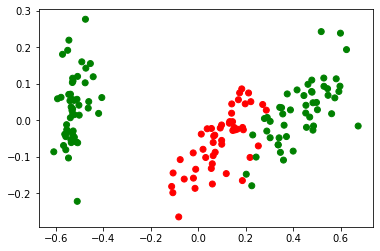

In [6]:
plt.scatter(X_reduced[:,0],X_reduced[:,1], c=colors)
plt.show()

In [7]:
import sys

sys.path.append('..')

from flod.classifiers.bsvclassifier import BSVClassifier

We keep only 33% of the dataset as test set.

We shuffle and stratify, since the outliers are not the same amount as the regular points.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.33, shuffle=True, stratify=y)

In [9]:
clf = BSVClassifier(n_iter=10, c=.25, q=100, penalization=200)
clf.fit(X_train, y_train)

Estimated kernel_values size 1.6722828149795532e-05 GB


BSVClassifier(c=0.25, init_bound=0.1, n_iter=10, penalization=200, q=100,
              random_seed=42)

In [10]:
y_pred = clf.predict(X_test)

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print(f'Precision {precision_score(y_test, y_pred)}')
print(f'Recall {recall_score(y_test, y_pred)}')
print(f'F1 {f1_score(y_test, y_pred)}')
print(f'Accuracy {accuracy_score(y_test, y_pred)}')

Precision 0.9444444444444444
Recall 1.0
F1 0.9714285714285714
Accuracy 0.98


In [12]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        33
           1       0.94      1.00      0.97        17

    accuracy                           0.98        50
   macro avg       0.97      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50



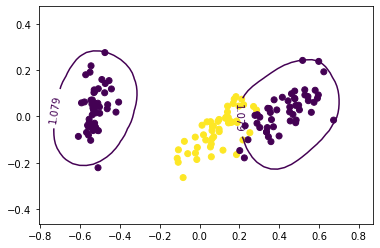

In [13]:
gx = np.linspace(min(X_reduced[:,0])-.2, max(X_reduced[:,0])+.2, 50)
gy = np.linspace(min(X_reduced[:,1])-.2, max(X_reduced[:,1])+.2, 50)
gX, gY = np.meshgrid(gx, gy)
zs = np.array([clf._compute_r(np.array([x, y])) for x, y in zip(np.ravel(gX), np.ravel(gY))])
gZ = zs.reshape(gX.shape)
membership_contour = plt.contour(gX, gY, gZ, levels=(clf.radiuses_[clf.sv_i], ))
plt.clabel(membership_contour, inline=1)

plt.scatter(X_reduced[:,0],X_reduced[:,1], c=y)
plt.show()

In [14]:
from joblib import dump, load
dump(clf, 'iris.joblib') 

['iris.joblib']

# Let's setup a Pipeline

We split train and test the same as above.

In [15]:
from scipy.stats import randint, uniform
from sklearn.model_selection import cross_validate
from tqdm.notebook import tqdm

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold


pipe = Pipeline([
        ('scaler', MaxAbsScaler()),
        ('reduce_dim', PCA('mle')),
        ('classifier', BSVClassifier())
])

params = {
    'scaler': [StandardScaler(), MaxAbsScaler(), RobustScaler(), QuantileTransformer()],
    'classifier__n_iter': [10],
    'classifier__penalization': randint(0, 500),
    'classifier__q': randint(0, 500),
    'classifier__c': uniform()    
}

scoring = ['precision', 'recall', 'f1']

Inner loop aka RandomizedSearchCV to find the best model given the data.
Outer loop to see if the best model was just lucky or all the best models perform well.

In [17]:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True)
inner_cv = StratifiedKFold(n_splits=2, shuffle=True)


clf = RandomizedSearchCV(pipe, params, n_jobs=-1, cv=inner_cv, refit='f1', verbose=10, return_train_score=False, scoring=scoring, n_iter=10)
scores = cross_validate(clf, X=X, y=y, cv=outer_cv, n_jobs=-1, scoring=scoring, verbose=10, return_estimator=True, return_train_score=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  7.0min remaining: 10.5min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  7.0min remaining:  4.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 11.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 11.7min finished


In [18]:
scores

{'fit_time': array([415.66086793, 427.88870931, 356.67845345, 413.91563749,
        340.07449341]),
 'score_time': array([0.06421065, 0.05745029, 0.15289664, 0.12532949, 0.04020238]),
 'estimator': (RandomizedSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=True),
                     error_score=nan,
                     estimator=Pipeline(memory=None,
                                        steps=[('scaler',
                                                MaxAbsScaler(copy=True)),
                                               ('reduce_dim',
                                                PCA(copy=True,
                                                    iterated_power='auto',
                                                    n_components='mle',
                                                    random_state=None,
                                                    svd_solver='auto', tol=0.0,
                                                    whiten=False)),
   

In [20]:
import pandas as pd

cv_res = pd.DataFrame(scores)
cv_res

,fit_time,score_time,estimator,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
0,415.660868,0.064211,RandomizedSearchCV(cv=StratifiedKFold(n_splits...,0.900000,1.000000,0.9,0.925,0.900000,0.961039
1,427.888709,0.057450,RandomizedSearchCV(cv=StratifiedKFold(n_splits...,0.625000,0.973684,1.0,0.925,0.769231,0.948718
2,356.678453,0.152897,RandomizedSearchCV(cv=StratifiedKFold(n_splits...,0.818182,0.950000,0.9,0.950,0.857143,0.950000
3,413.915637,0.125329,RandomizedSearchCV(cv=StratifiedKFold(n_splits...,0.909091,0.972222,1.0,0.875,0.952381,0.921053
4,340.074493,0.040202,RandomizedSearchCV(cv=StratifiedKFold(n_splits...,0.692308,0.883721,0.9,0.950,0.782609,0.915663


# TODO

1. Perform analisys on cross validation results
1. Try to increase number of inner splits
1. Add comments in all the notebook